In [17]:
import torch
import torch.nn.functional as F
from torch import nn
import pandas as pd
import matplotlib.pyplot as plt # for making figures
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from pprint import pprint

In [18]:
torch.__version__

'2.4.0'

In [19]:
device = torch.device("cuda")
device

device(type='cuda')

In [20]:
text = open("/kaggle/input/war-and-peace/war_and_peace.txt", mode='r')
lines = text.readlines()
words = pd.Series(lines)
words 

0        "Well, Prince, so Genoa and Lucca are now just...
1        Buonapartes. But I warn you, if you don't tell...
2        if you still try to defend the infamies and ho...
3        Antichrist--I really believe he is Antichrist-...
4        to do with you and you are no longer my friend...
                               ...                        
20376    on the steps in the "reception room"--as Denis...
20377    hut--and it was then so warm that the officers...
20378    always some with Denisov and Rostov, sat in th...
20379                                                   \n
20380                        In April, Rostov was on order
Length: 20381, dtype: object

In [21]:
words = words.str.lower()
words = words.str.strip()
words = words.str.replace("\n", "")
words = words.str.replace('"', '')
words = words.str.replace(',', '')
words = words.str.replace('.', '')
words = words.str.replace('!', '')
words = words.str.replace("'", "")
words = words.str.replace("-", "")
words = words.str.replace("?", "")
words = words.str.replace("(", "")
words = words.str.replace(")", "")
words = words.str.replace(";", "")
words = words.str.replace(":", "")
words = words.str.strip()

In [22]:
words = words.sample(frac=1).reset_index(drop=True)
words = words.tolist()

In [23]:
words[:10]

['were firing at our men prince bagration bowed his head as a sign that',
 'i must be mistaken he must be feeling happy just as i am',
 '',
 'the elderly lady was a princess drubetskaya belonging to one of the',
 'oh thats it said rostov evidently thinking of something else',
 'head and continued in a whisper has he performed his final duty',
 '',
 '',
 '',
 '']

In [24]:
chars = sorted(list(set((" ".join(words)).split(" "))))
stoi = {s:i+2 for i,s in enumerate(chars)}
stoi['.'] = 1
stoi['<S>'] = 0
itos = {i:s for s,i in stoi.items()}
print(len(itos))

11189


In [25]:
block_size = 5 # context length: how many words/characters do we take to predict the next one?
X, Y = [], []
for w in words[:]:
  
  # print(w)
  context = [0] * block_size
  for ch in (w.split(" ") + ['<S>']):
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    # print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append
  
# Move data to GPU

X = torch.tensor(X).to(device)
Y = torch.tensor(Y).to(device)

In [26]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([204978, 5]), torch.int64, torch.Size([204978]), torch.int64)

In [27]:
emb_dim = 64
emb = torch.nn.Embedding(len(stoi), emb_dim)
emb.weight

Parameter containing:
tensor([[ 0.6458,  1.5572,  0.0573,  ...,  1.6361,  0.4849, -1.3507],
        [ 0.6896,  1.2465, -1.2506,  ..., -0.4261, -0.6615,  0.5565],
        [ 0.3829,  1.2040, -0.1560,  ...,  0.0884,  0.2752,  0.5481],
        ...,
        [ 0.1477, -0.9182,  0.0249,  ..., -1.2201,  0.1874,  1.5034],
        [-0.4784,  2.0619,  1.1193,  ...,  0.2290, -0.4804,  0.2405],
        [ 0.4701,  0.2986, -0.0146,  ...,  0.9274, -0.2414, -0.3922]],
       requires_grad=True)

In [28]:
class NextChar(nn.Module):
    def __init__(self, block_size, vocab_size, emb_dim, hidden_size):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim)
        self.lin1 = nn.Linear(block_size*emb_dim, hidden_size)
        self.lin2 = nn.Linear(hidden_size, vocab_size)

    def forward(self, x):
        x = self.emb(x)
        x = x.view(x.shape[0], -1)
        x = nn.functional.relu(self.lin1(x))
        x = self.lin2(x)
        return x 

In [29]:
import torch._dynamo
torch._dynamo.config.suppress_errors = True

model = NextChar(block_size, len(stoi), emb_dim, 512).to(device)
model = torch.compile(model)

g = torch.Generator()
g.manual_seed(4000002)
def generate_words(model, itos, stoi, block_size, max_len=100):
    context = [0] * block_size
    name = ''
    for i in range(max_len):
        x = torch.tensor(context).view(1, -1).to(device)
        y_pred = model(x)
        ix = torch.distributions.categorical.Categorical(logits=y_pred).sample().item()
        # print(ix)
        ch = itos[ix]
        if ch == '<S>':
            break
        if ch not in ['"', ',', '.', '!', "'", "-", "?", "(", ")", ";", ":"]:
            name += ' '+ ch
        else:
            name += ch
        context = context[1:] + [ix]
    return name

for i in range(10):
    print(generate_words(model, itos, stoi, block_size))

W1026 14:10:19.114000 138106874963776 torch/_dynamo/convert_frame.py:1009] WON'T CONVERT forward /tmp/ipykernel_30/1837562056.py line 8 
W1026 14:10:19.114000 138106874963776 torch/_dynamo/convert_frame.py:1009] due to: 
W1026 14:10:19.114000 138106874963776 torch/_dynamo/convert_frame.py:1009] Traceback (most recent call last):
W1026 14:10:19.114000 138106874963776 torch/_dynamo/convert_frame.py:1009]   File "/opt/conda/lib/python3.10/site-packages/torch/_dynamo/convert_frame.py", line 948, in __call__
W1026 14:10:19.114000 138106874963776 torch/_dynamo/convert_frame.py:1009]     result = self._inner_convert(
W1026 14:10:19.114000 138106874963776 torch/_dynamo/convert_frame.py:1009]   File "/opt/conda/lib/python3.10/site-packages/torch/_dynamo/convert_frame.py", line 472, in __call__
W1026 14:10:19.114000 138106874963776 torch/_dynamo/convert_frame.py:1009]     return _compile(
W1026 14:10:19.114000 138106874963776 torch/_dynamo/convert_frame.py:1009]   File "/opt/conda/lib/python3.10

 remark century novel uncover curving bump eagle fail pavlovnawho passagestwenty they tomorrow reckless majestys autumnal orchestra academy curly wonderful slipping weight scared depressed form remain anonymous escapade mundi scaffolding wellordered vanquished width lights establishing aide desires proud off sway meanness relation breathing nous oldage box lichtenstein sped courtiers ive twentyyearold arrival irregularly boots vive exceptional memorandum gust sewn castle thresh amstetten whim calls mortified wifethose embracing enthusiast jesus condescend away tangled grasping questionmost selfrespect omnipotence generations successful positively discussion determination azov ce blunders offerings stages washed trifling simultaneous renewed sober francis inaudible then gliding rubbles noisily endeavor daily didnt owed
 cloaks novosiltsevs teased wincing part expecting fwo transformed thanked messieurs breathlessly sweets trap cradle locks copenhagena atom forced muddle glogau chip sall

In [30]:
for param_name, param in model.named_parameters():
    print(param_name, param.shape)

_orig_mod.emb.weight torch.Size([11189, 64])
_orig_mod.lin1.weight torch.Size([512, 320])
_orig_mod.lin1.bias torch.Size([512])
_orig_mod.lin2.weight torch.Size([11189, 512])
_orig_mod.lin2.bias torch.Size([11189])


In [31]:
len(stoi)

11189

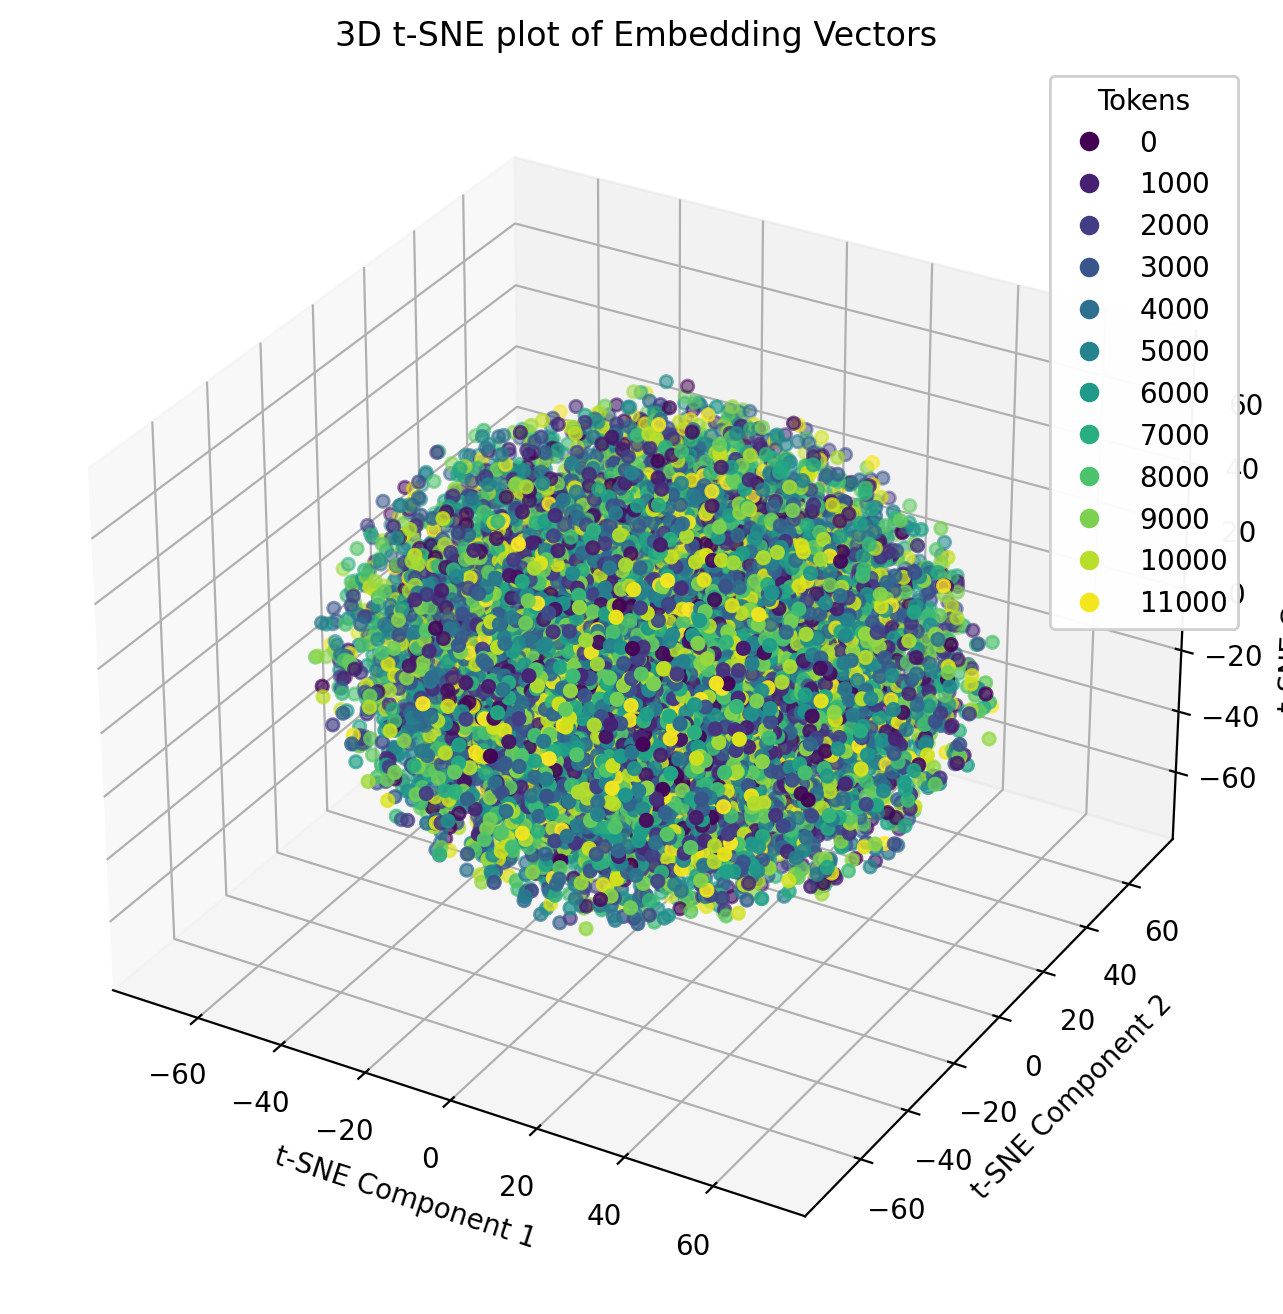

In [32]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import numpy as np
from mpl_toolkits.mplot3d import Axes3D  # Import the 3D plotting toolkit

emb_curr = model.emb
embeddings = emb_curr.weight.detach().cpu().numpy()

pca = PCA(n_components=20, random_state=42)
embeddings_pca = pca.fit_transform(embeddings)

tsne = TSNE(n_components=3, random_state=42)
X_embedded = tsne.fit_transform(embeddings_pca)

tokens = list(stoi.keys())

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')  # Create a 3D subplot

scatter = ax.scatter(X_embedded[:, 0], X_embedded[:, 1], X_embedded[:, 2], 
                     c=np.arange(len(tokens)), cmap='viridis', marker='o')

legend1 = ax.legend(*scatter.legend_elements(), title="Tokens")
ax.add_artist(legend1)

ax.set_title('3D t-SNE plot of Embedding Vectors')
ax.set_xlabel('t-SNE Component 1')
ax.set_ylabel('t-SNE Component 2')
ax.set_zlabel('t-SNE Component 3')

plt.show()

In [33]:
import time
l1_lambda = 0.000007  # Regularization strength for L1 norm

# Loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.AdamW(model.parameters(), lr=0.00007)

# Mini-batch training
batch_size = 4000
print_every = 10
elapsed_time = []

for epoch in range(1000):
    start_time = time.time()
    
    for i in range(0, X.shape[0], batch_size):
        x = X[i:i+batch_size]
        y = Y[i:i+batch_size]
        
        try:
            if x.shape[0] != 0:
                # Forward pass
                y_pred = model(x)
                loss = loss_fn(y_pred, y)
                loss = loss.to(device)

                # Compute L1 norm (sum of absolute values of weights)
                l1_norm = sum(torch.sum(torch.abs(param)) for param in model.parameters())

                # Add L1 regularization to the loss
                loss += l1_lambda * l1_norm

                # Backward pass
#                 print(y_pred)
#                 print(y)
                loss.backward()
                opt.step()
                opt.zero_grad()
        except:
            pass

    end_time = time.time()
    elapsed_time.append(end_time - start_time)
    try:
        if epoch % print_every == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')
    except:
        pass


Epoch 0, Loss: 13.357301712036133
Epoch 10, Loss: 10.378546714782715
Epoch 20, Loss: 9.598701477050781
Epoch 30, Loss: 8.957886695861816
Epoch 40, Loss: 8.365494728088379
Epoch 50, Loss: 7.805263519287109
Epoch 60, Loss: 7.27278470993042
Epoch 70, Loss: 6.7725934982299805
Epoch 80, Loss: 6.325839996337891
Epoch 90, Loss: 5.954929828643799
Epoch 100, Loss: 5.661463737487793
Epoch 110, Loss: 5.427719593048096
Epoch 120, Loss: 5.234394073486328
Epoch 130, Loss: 5.06876277923584
Epoch 140, Loss: 4.922729015350342
Epoch 150, Loss: 4.791199684143066
Epoch 160, Loss: 4.670660018920898
Epoch 170, Loss: 4.558512210845947
Epoch 180, Loss: 4.4530863761901855
Epoch 190, Loss: 4.353185653686523
Epoch 200, Loss: 4.258248805999756
Epoch 210, Loss: 4.167778015136719
Epoch 220, Loss: 4.081411361694336
Epoch 230, Loss: 3.9990196228027344
Epoch 240, Loss: 3.920341968536377
Epoch 250, Loss: 3.8452632427215576
Epoch 260, Loss: 3.7736639976501465
Epoch 270, Loss: 3.7053394317626953
Epoch 280, Loss: 3.639995

In [34]:
for i in range(10):
    print(generate_words(model, itos, stoi, block_size))

 destroyed and was the same to another soldier near round toward another without another without something turned away but it if you like your
 dispatch the english dimly who produced the first of those present and on leaving with her soldiers looked
 us returned the doctor and yet remaining to the
 he pulled off to the emperor and approaching which she had known after free to tears that it was in what
 to the soldiers princess and moved forward from her
 
 
 given himself that very often and three and above it
 animation and cost the activities of his thriving to suites and decision
 


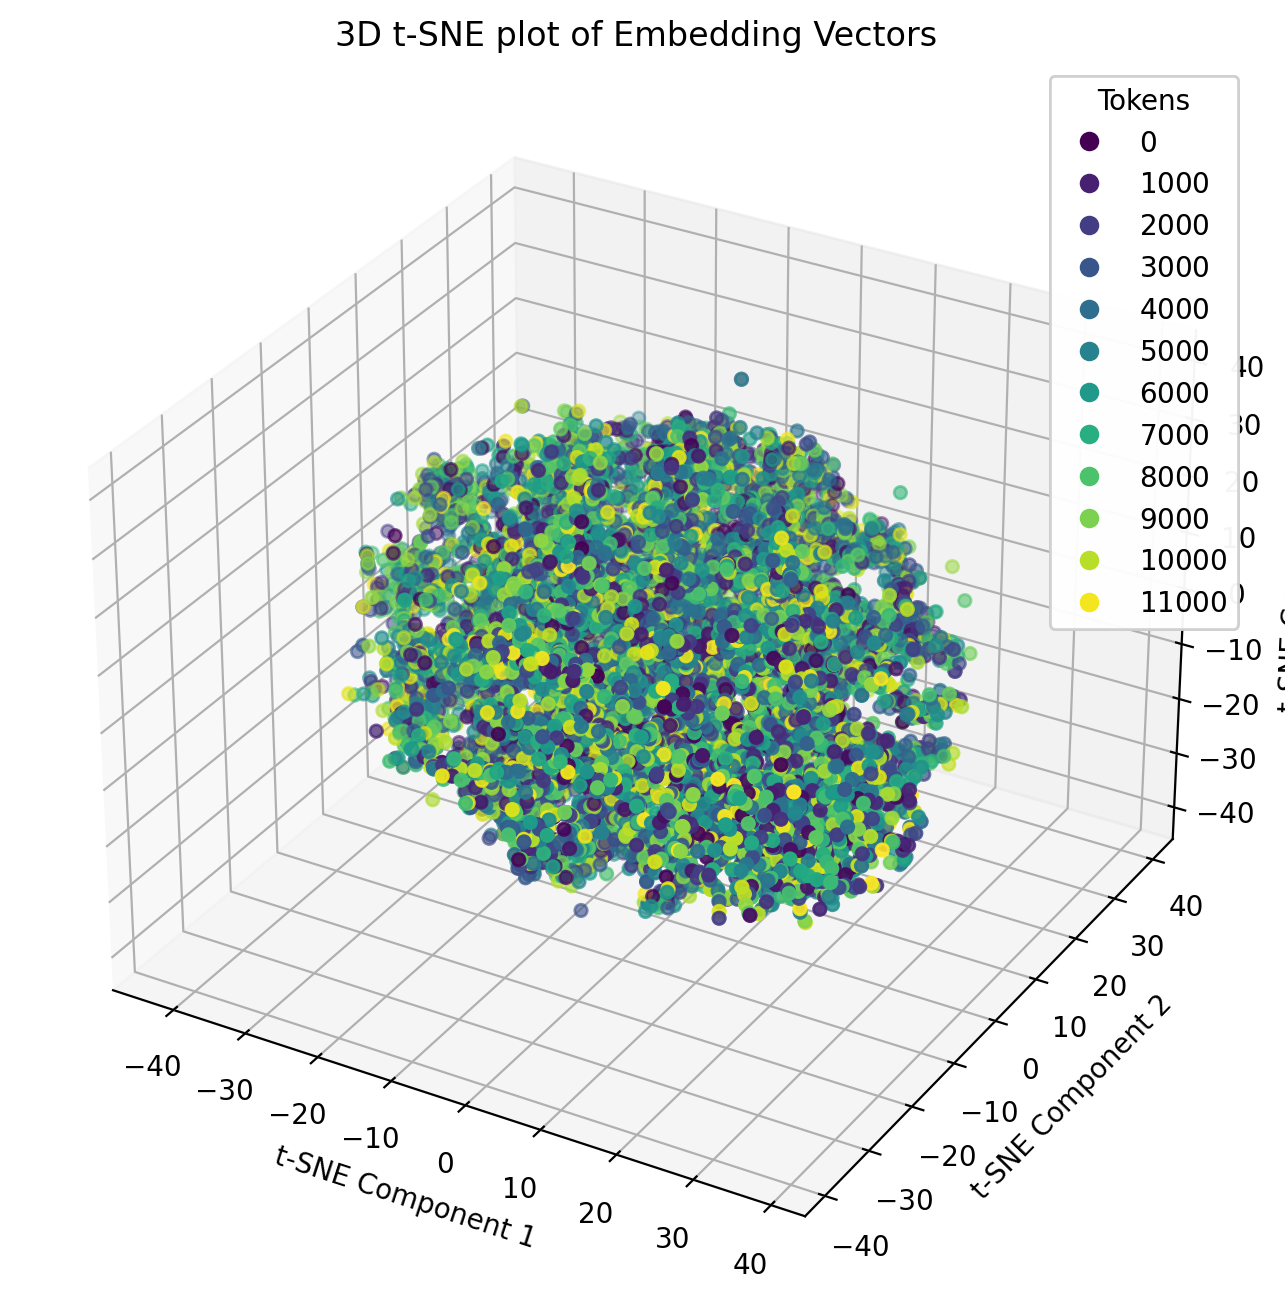

In [35]:
emb_curr = model.emb
embeddings = emb_curr.weight.detach().cpu().numpy()

# Perform PCA to reduce to 50 dimensions
pca = PCA(n_components=20, random_state=42)
embeddings_pca = pca.fit_transform(embeddings)

# Perform t-SNE on the PCA-reduced embeddings with 3 components
tsne = TSNE(n_components=3, random_state=42)
X_embedded = tsne.fit_transform(embeddings_pca)

# Get the token names (keys from stoi) in the same order as embeddings
tokens = list(stoi.keys())

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')  # Create a 3D subplot

scatter = ax.scatter(X_embedded[:, 0], X_embedded[:, 1], X_embedded[:, 2], 
                     c=np.arange(len(tokens)), cmap='viridis', marker='o')

# Create legend labels based on tokens
legend1 = ax.legend(*scatter.legend_elements(), title="Tokens")
ax.add_artist(legend1)

# Add title and labels for each axis
ax.set_title('3D t-SNE plot of Embedding Vectors')
ax.set_xlabel('t-SNE Component 1')
ax.set_ylabel('t-SNE Component 2')
ax.set_zlabel('t-SNE Component 3')

plt.show()


In [36]:
model_cpu = model.cpu()

torch.save(model_cpu.state_dict(), "model_5_64_512_r.pth")

In [37]:
model = model.to(device)

In [38]:
pd_itos_i = [i for s,i in stoi.items()]
pd_itos_s = [s for s,i in stoi.items()]

pd_itos = pd.DataFrame({"i":pd_itos_i, "s":pd_itos_s})
pd_stoi = pd.DataFrame({"s":pd_itos_s, "i":pd_itos_i})

pd_itos.to_csv('itos.csv')
pd_stoi.to_csv('stoi.csv')